In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_moons


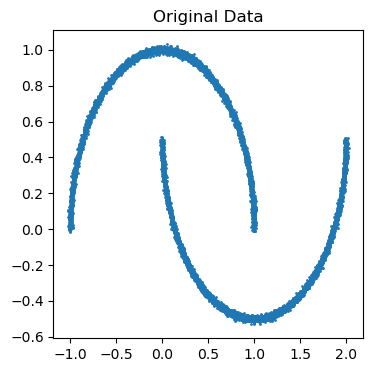

In [7]:

# =====================================================
# 1. 데이터 생성 및 시각화
# =====================================================
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_samples = 10000

# 2차원 make_moons 데이터셋 생성
x0_np, _ = make_moons(n_samples, noise=0.01)
x0 = torch.from_numpy(x0_np).float()

plt.figure(figsize=(4,4))
plt.scatter(x0[:, 0].numpy(), x0[:, 1].numpy(), s=1)
plt.title("Original Data")
plt.show()


In [8]:

# =====================================================
# 2. 연속시간 임베딩 함수
#    (sinusoidal embedding; Diffusion/Transformer에서 자주 사용하는 방식)
# =====================================================
def get_t_embedding(t, emb_dim):
    """
    t: (B, 1) 텐서, 값은 [0, 1] 범위
    emb_dim: 임베딩 차원
    """
    half_dim = emb_dim // 2
    # 주파수 벡터 (scale factor)
    freqs = torch.exp(torch.arange(half_dim, device=t.device).float() * -(math.log(10000.0) / (half_dim - 1)))
    # t: (B,1)와 freqs: (half_dim,)의 곱 → (B, half_dim)
    args = t * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if emb_dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros(emb.size(0), 1, device=t.device)], dim=-1)
    return emb  # (B, emb_dim)


In [9]:

# =====================================================
# 3. Flow Matching 모델 정의
#    - 입력: x (2d)와 연속 시간 t (shape: [B, 1])
#    - 출력: 해당 위치에서의 속도장 (2d)
# =====================================================
class FlowMLP(nn.Module):
    def __init__(self, n_dim=2, n_hidden=256, time_emb_dim=256):
        super().__init__()
        self.n_hidden = n_hidden
        self.time_emb_dim = time_emb_dim
        
        # x 임베딩 (피처 추출)
        self.x_emb = nn.Sequential(
            nn.Linear(n_dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.GELU()
        )
        # 시간 임베딩 (연속 t를 임베딩)
        self.t_fc = nn.Sequential(
            nn.Linear(time_emb_dim, n_hidden),
            nn.GELU()
        )
        # 두 임베딩을 합친 후 최종 속도장 예측 (2d 출력)
        self.fc = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_dim)
        )
        
    def forward(self, x, t):
        # x: (B, 2), t: (B, 1) – 연속값 [0, 1]
        t_emb = get_t_embedding(t, self.time_emb_dim)  # (B, time_emb_dim)
        x_emb = self.x_emb(x)                          # (B, n_hidden)
        t_emb = self.t_fc(t_emb)                         # (B, n_hidden)
        h = x_emb + t_emb
        out = self.fc(h)  # (B, 2) → 예측된 속도장
        return out

# 모델 생성 및 옵티마이저 설정
model = FlowMLP(n_dim=2, n_hidden=256, time_emb_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 데이터셋을 device로 이동
x0 = x0.to(device)


Training Flow Matching:   3%|▎         | 347/10000 [00:00<00:07, 1262.27it/s]

Iteration 0: Loss = 1.362081527709961


Training Flow Matching:  12%|█▏        | 1248/10000 [00:00<00:05, 1730.40it/s]

Iteration 1000: Loss = 1.0408278703689575


Training Flow Matching:  23%|██▎       | 2317/10000 [00:01<00:04, 1756.52it/s]

Iteration 2000: Loss = 0.9896044135093689


Training Flow Matching:  32%|███▏      | 3199/10000 [00:01<00:03, 1742.54it/s]

Iteration 3000: Loss = 0.9749988317489624


Training Flow Matching:  43%|████▎     | 4272/10000 [00:02<00:03, 1771.56it/s]

Iteration 4000: Loss = 1.1530139446258545


Training Flow Matching:  53%|█████▎    | 5343/10000 [00:03<00:02, 1773.41it/s]

Iteration 5000: Loss = 1.0699474811553955


Training Flow Matching:  62%|██████▏   | 6238/10000 [00:03<00:02, 1784.10it/s]

Iteration 6000: Loss = 0.9436781406402588


Training Flow Matching:  73%|███████▎  | 7325/10000 [00:04<00:01, 1794.49it/s]

Iteration 7000: Loss = 1.105000615119934


Training Flow Matching:  82%|████████▏ | 8220/10000 [00:04<00:01, 1768.52it/s]

Iteration 8000: Loss = 0.9114560484886169


Training Flow Matching:  93%|█████████▎| 9292/10000 [00:05<00:00, 1780.06it/s]

Iteration 9000: Loss = 0.9059798717498779


Training Flow Matching: 100%|██████████| 10000/10000 [00:05<00:00, 1731.71it/s]


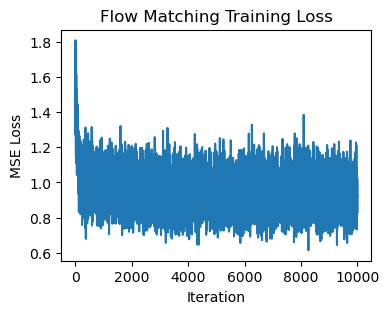

In [10]:

# =====================================================
# 4. Flow Matching 학습
#    - 목표: x_t = (1-t)x_0 + t*z (선형 보간)
#      에서 목표 속도장은 d/dt x_t = z - x_0
# =====================================================
n_iter = 10000
batch_size = 128
loss_history = []

model.train()
for i in tqdm(range(n_iter), desc="Training Flow Matching"):
    # 데이터 배치 샘플링
    idx = torch.randint(0, n_samples, (batch_size,), device=device)
    x_data = x0[idx]  # (B, 2)
    
    # 노이즈 샘플: z ~ N(0, I)
    z = torch.randn(batch_size, 2, device=device)
    
    # 연속 t ∈ [0, 1]를 균등 샘플링 (shape: (B, 1))
    t = torch.rand(batch_size, 1, device=device)
    
    # 선형 보간: x_t = (1-t)x_data + t*z
    x_t = (1 - t) * x_data + t * z
    
    # 목표 속도: d/dt x_t = z - x_data
    target_v = z - x_data  # (B, 2)
    
    # 모델 예측: v(x_t, t)
    pred_v = model(x_t, t)
    
    loss = F.mse_loss(pred_v, target_v)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if i % 1000 == 0:
        print(f"Iteration {i}: Loss = {loss.item()}")

plt.figure(figsize=(4,3))
plt.plot(loss_history)
plt.title("Flow Matching Training Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.show()


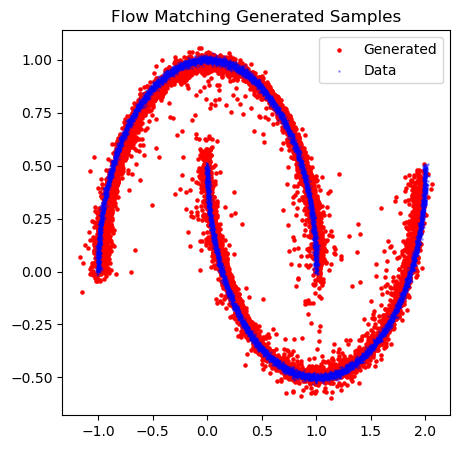

In [11]:

# =====================================================
# 5. 생성: 학습된 속도장을 이용해 ODE 풀기
#    - ODE: dx/dt = -v(x,t)
#    - 초기조건: t=1일 때 x(1)=z (노이즈 샘플)
#    - Euler 방법을 이용하여 t=1 → t=0 방향으로 통합
# =====================================================
@torch.no_grad()
def generate_samples(model, batch_size=1000, n_steps=100):
    model.eval()
    dt = 1.0 / n_steps
    # t=1에서 초기 샘플은 노이즈
    x = torch.randn(batch_size, 2, device=device)
    # t=1부터 0까지 Euler integration (역방향)
    for i in range(n_steps):
        t_val = 1 - i * dt  # 현재 시간 (감소)
        t_tensor = torch.full((batch_size, 1), t_val, device=device)
        v = model(x, t_tensor)  # 예측 속도장
        # ODE: dx/dt = -v(x,t)
        x = x - dt * v
    return x

gen_samples = generate_samples(model, batch_size=10000, n_steps=100)
gen_samples_np = gen_samples.cpu().numpy()
x0_np = x0.cpu().numpy()

plt.figure(figsize=(5,5))
plt.scatter(gen_samples_np[:, 0], gen_samples_np[:, 1], s=5, c='red', label='Generated')
plt.scatter(x0_np[:, 0], x0_np[:, 1], s=1, c='blue', alpha=0.3, label='Data')
plt.legend()
plt.title("Flow Matching Generated Samples")
plt.show()
